# MLEA : Arbres de Décisions

## ID3 : ToyProblem

#### Data

In [3]:
from io import StringIO
from graphviz import Digraph
import pandas as pd
import numpy as np

In [4]:
csv_data = StringIO("""
Outlook,Temperature,Humidity,Wind
Sunny,Hot,High,Weak
Sunny,Hot,High,Strong
Overcast,Hot,High,Weak
Rain,Mild,High,Weak
Rain,Cool,Normal,Weak
Rain,Cool,Normal,Strong
Overcast,Cool,Normal,Strong
Sunny,Mild,High,Weak
Sunny,Cool,Normal,Weak
Rain,Mild,Normal,Weak
Sunny,Mild,Normal,Strong
Overcast,Mild,High,Strong
Overcast,Hot,Normal,Weak
Rain,Mild,High,Strong
""")

In [5]:
df = pd.read_csv(csv_data, sep=',',header=0)
df

,Outlook,Temperature,Humidity,Wind
0,Sunny,Hot,High,Weak
1,Sunny,Hot,High,Strong
2,Overcast,Hot,High,Weak
3,Rain,Mild,High,Weak
4,Rain,Cool,Normal,Weak
5,Rain,Cool,Normal,Strong
6,Overcast,Cool,Normal,Strong
7,Sunny,Mild,High,Weak
8,Sunny,Cool,Normal,Weak
9,Rain,Mild,Normal,Weak


In [6]:
x_tennis = df
labels_tennis = np.array(["No", "No", "Yes", "Yes", "Yes", "No", "Yes", "No", "Yes", "Yes", "Yes", "Yes", "Yes", "No"])

### Implementation

#### Tree structure for ID3

In [7]:
class Node:
    
    ID = 0
    
    """Simple custom tree structures containing the ID3 data.
    
    """
    
    def __init__(self, dot, parent_attrib):
        """Creates a Node to be used in a general tree structure.
        
        Parameters
        ----------
        
        dot:
            The graphviz dot object.
            
        parent_attrib:
            Attribute of the parent
    
        """
        
        self.attribute = None
        self.label = None
        self.parent_attrib = parent_attrib
        self.dot = dot
        self.children = {}
    
    def setLabel(self, label, link_name):
        """Sets the label of the current node.
        
        Parameters
        ----------
        
        label:
            Value of the label.
    
        """

        self.label = label
        node_label = "{}_{}".format(label, Node.ID)
        self.dot.node(node_label, label, color='green', shape='diamond')
        self.dot.edge(self.parent_attrib, node_label, label=link_name)

        # This static ID is a way to create
        # new label node, without having conflict.
        Node.ID = Node.ID + 1
    
    def update_dot(self, entropy):
        """Updates the value of the node, by specifying its atrribute,
        as well as making the link in the dot tree, for rendering.
        
        Parameters
        ----------
        
        attribute:
            Value of the attribute of the node.
    
        """
        
        # This is gross, but it allows to easily
        # pretty print the tree.
        attribute = self.attribute
        attr_str = "{}\nEntropy: {:.2f}".format(attribute, entropy)
        self.dot.node(attribute, attr_str)
        for child_key in self.children:
            child_attr = self.children[child_key].attribute
            if not(child_attr is None):
                self.dot.edge(attribute, child_attr, label=child_key)
        
    
    def add(self, idx, attribute=None):
        """Adds a new node as a child, using a custom edge
        value.
        
        Parameters
        ----------
        
        idx:
            Name of the edge added between self and the new node.
    
        """
        self.children[idx] = Node(self.dot, self.attribute)
        return self.children[idx]

In [227]:
class ID3:
    
    @staticmethod
    def entropy(s, unique_labels):
        """Computes the entropy of a given set of values.
        
        Parameters
        ----------
        
        s:
            The set on which the entropy is computed.
    
        """
        # Used to avoid having invalid value in the logarithm.
        EPSILON = 0.0001
        nb_rows = len(s)
        entropy = 0.0
        for label in unique_labels:
            label_count = 0
            for i in range(0, nb_rows):
                if s[i] == label:
                    label_count += 1
            proba = (label_count / nb_rows) + 0.0001
            entropy += - proba * np.log2(proba)
        return entropy
    
    @staticmethod
    def gini_index(s, unique_labels):
        nb_rows = len(s)
        value = 1.0
        for label in unique_labels:
            label_count = 0
            for i in range(0, nb_rows):
                if s[i] == label:
                    label_count += 1
            proba = (label_count / nb_rows)
            value -= proba * proba
        return value

    @staticmethod
    def gain(s, target_attrib,
             attributes, x, y, unique_labels, giny):
        """Computes the gain .
        
        Parameters
        ----------
        
        s:
            The set on which the entropy is computed.
    
        """
        
        column = x.loc[:, target_attrib][s]
        values = attributes[target_attrib]
        nb_rows = len(s)
        
        gain = ID3.entropy(y[s], unique_labels)
        
        for value in values:
            indices = column.index[column.loc[:] == value]
            factor = len(indices) / nb_rows
            y_new = y[indices.tolist()]
            if (len(y_new) == 0):
                continue

            if not(giny):
                gain += - factor * ID3.entropy(y_new, unique_labels)
            else:
                gain += - factor * ID3.gini_index(y_new, unique_labels)
            
        return gain
    
    @staticmethod
    def intrinsec_value(s, target_attrib, attributes, x, y):
        EPSILON = 0.0001
        
        column = x.loc[:, target_attrib][s]
        values = attributes[target_attrib]
        nb_rows = len(s)
        
        gain = 0.0
        for value in values:
            indices = column.index[column.loc[:] == value]
            factor = len(indices) / nb_rows
            y_new = y[indices.tolist()]
            if (len(y_new) == 0):
                continue

            gain += - factor * np.log2(factor + EPSILON)
            
        return gain
    
    @staticmethod
    def compute_best_attr(s, attributes, x, y, unique_labels, split_type, giny):
        best_gain = -0.01
        best_attribute = None
        
        for attr in attributes:
            gain = 0.0
            if split_type == 'information_gain':
                gain = ID3.gain(s, attr, attributes, x, y, unique_labels, giny)
            elif split_type == 'gain_ratio':
                gain = ID3.gain(s, attr, attributes, x, y, unique_labels, giny)
                intrinsec = ID3.intrinsec_value(s, attr, attributes, x, y)
                gain = gain / intrinsec
            else:
                raise ValueError('Invalid splitting type provided!')

            if gain > best_gain:
                best_gain = gain
                best_attribute = attr
                
        return best_attribute
    
    def __build(self, node, label,
                x, y, s, attributes, unique_labels, split_type, giny):
        unique = np.unique(y[s])
        if unique.shape[0] < 2:
            if unique.shape[0] == 0:
                return
            node.setLabel(unique[0], label)
            return

        # Choose the best attribute for classification.
        best_attribute = ID3.compute_best_attr(
            s, attributes, x, y, unique_labels, split_type, giny
        )

        column = x.loc[s, best_attribute]
        values = attributes[best_attribute]
        
        del attributes[best_attribute]
        if len(attributes) == 0:
            return
        
        node.attribute = best_attribute
    
        for value in values:
            # Adds a child node pointed by value, and
            # then we can recursively create it.
            new_s = column.index[column.loc[:] == value].tolist()
            child = node.add(value)
            self.__build(
                child, value, x, y, new_s,
                dict(attributes), unique_labels, split_type, giny
            )
            
        entropy_val = ID3.entropy(y[s], unique_labels)
        node.update_dot(entropy_val)
    
    def __init__(self, x, y, split_type="information_gain", giny=False):
        unique_labels = set(y)
        
        # This maps store, for all attributes, a
        # set of unique values.
        unique_attributes = {}
        for column in enumerate(x.columns):
            column_id = column[1]
            unique_attributes[column_id] = set(x.loc[:, column_id])
        
        # Creates the Digraph used for pretty printing.
        # We will shape it to make it look good!
        self.dot = Digraph(comment='The Round Table')
        self.dot.attr('node', shape='component')
        
        s = [i for i in range(0, len(y))]
        self.root = Node(self.dot, None)
        self.__build(
            self.root, None, x, y, s,
            unique_attributes, unique_labels, split_type, giny
        )
        
    def predict(self, x):
        node = self.root
        label = None
        while True:
            # We found the leaf node, return the label
            if len(node.children) == 0:
                return node.label
            
            key = node.attribute
            if not(key in x):
                return None
            
            value = x[key]
            # This value does not exist in the tree
            if not(value in node.children):
                return None

            branch = x[node.attribute]
            # We are in the middle of the 
            node = node.children[branch]

### Utils for prediction

The function below will be used to test the prediction

In [240]:
def performance(x_train, y_train, **kwargs):
    x_test = kwargs.get("x_test", x_train)
    y_test = kwargs.get("y_test", y_train)
    split_type = kwargs.get("split_type", "information_gain")
    giny = kwargs.get("giny", False)
    # Training: builds the tree
    tree = ID3(x_train, y_train, split_type, giny)
    
    # Counts the number of success
    nb_elt = len(y_test)
    counted_elt = nb_elt
    res = 0
    for i in range(0, nb_elt):
        pred = tree.predict(x_test.loc[i])
        if not(pred is None):
            res = res + 1 if pred == y_test[i] else res
        else:
            counted_elt -= 1
    res = res / nb_elt 
    return (res * 100.0)

#### PlayTennis test by Hand

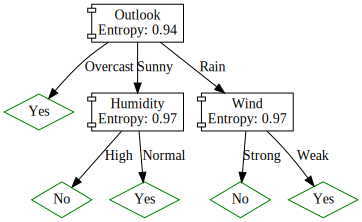

In [229]:
tree = ID3(x_tennis, labels_tennis)
tree.dot

In [230]:
test = x_tennis.loc[0]
print("Test with row 0, answer is {}".format(tree.predict(df.loc[0])))

Test with row 0, answer is No


#### PlayTennis test on train

In [231]:
print('PlayTennis, test on train:')
print('Accuracy: {}%'.format(performance(x_tennis, labels_tennis)))

PlayTennis, test on train:
Accuracy: 100.0%


## ID3 : Mushroom

### Data

Here, we split the data and the labels

In [232]:
def load_csv(file, label_idx):
    x = pd.read_csv(MUSHROOM_FILE, sep=',', header=0)
    # Extracts labels
    labels = np.array(x.loc[:, label_idx].tolist())
    # Removes lables from the data
    x = x.drop(label_idx, 1)
    
    return x, labels

In [233]:
MUSHROOM_FILE = "agaricus-lepiota.csv"
x_mushroom, labels_mushroom = load_csv(MUSHROOM_FILE, 'class')

In [234]:
x_mushroom

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,x,s,n,t,p,f,c,n,k,e,...,s,w,w,p,w,o,p,k,s,u
1,x,s,y,t,a,f,c,b,k,e,...,s,w,w,p,w,o,p,n,n,g
2,b,s,w,t,l,f,c,b,n,e,...,s,w,w,p,w,o,p,n,n,m
3,x,y,w,t,p,f,c,n,n,e,...,s,w,w,p,w,o,p,k,s,u
4,x,s,g,f,n,f,w,b,k,t,...,s,w,w,p,w,o,e,n,a,g
5,x,y,y,t,a,f,c,b,n,e,...,s,w,w,p,w,o,p,k,n,g
6,b,s,w,t,a,f,c,b,g,e,...,s,w,w,p,w,o,p,k,n,m
7,b,y,w,t,l,f,c,b,n,e,...,s,w,w,p,w,o,p,n,s,m
8,x,y,w,t,p,f,c,n,p,e,...,s,w,w,p,w,o,p,k,v,g
9,b,s,y,t,a,f,c,b,g,e,...,s,w,w,p,w,o,p,k,s,m


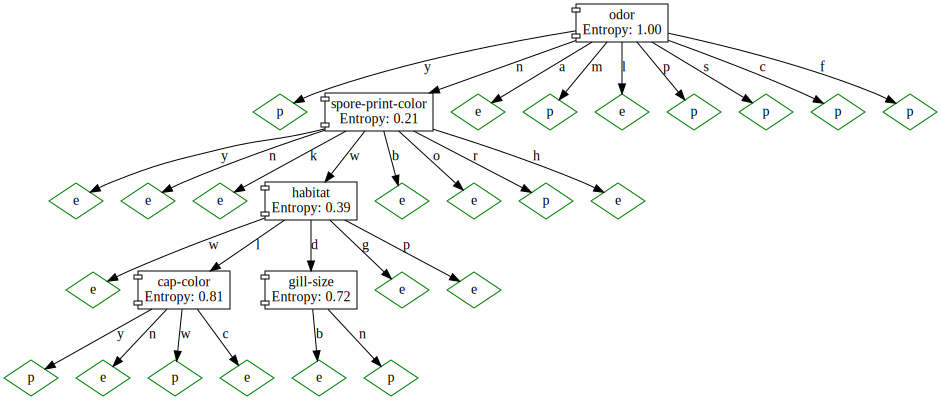

In [235]:
tree = ID3(x_mushroom, labels_mushroom)
tree.dot

In [236]:
print('Mushroom, test on train:')
print('Accuracy: {}%'.format(performance(x_mushroom, labels_mushroom)))

Mushroom, test on train:
Accuracy: 100.0%


### Gain Ratio

#### PlayTennis test

In [237]:
tree = ID3(x_tennis, labels_tennis, "gain_ratio")

print('PlayTennis test on train with Gain Ratio:')
print('Accuracy: {}%'.format(
    performance(x_tennis, labels_tennis, split_type="gain_ratio")
))

PlayTennis test on train with Gain Ratio:
Accuracy: 100.0%


#### Mushroom test

In [238]:
tree = ID3(x_mushroom, labels_mushroom, "gain_ratio")

print('PlayTennis test on train with Gain Ratio:')
print('Accuracy: {}%'.format(
    performance(x_mushroom, labels_mushroom, split_type="gain_ratio")
))

PlayTennis test on train with Gain Ratio:
Accuracy: 100.0%


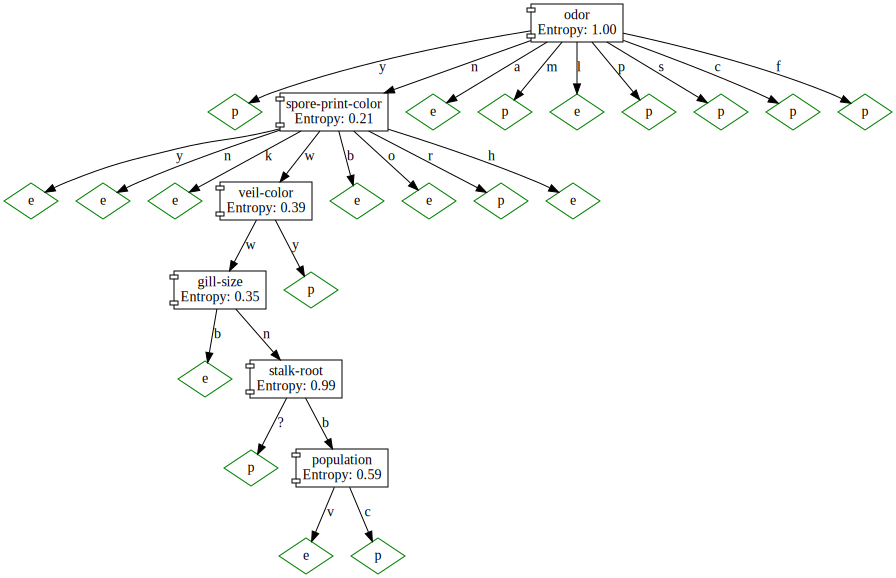

In [239]:
tree.dot

### Information Gain & Gini

#### PlayTennis test

In [243]:
tree = ID3(x_tennis, labels_tennis, "information_gain", True)

print('PlayTennis test on train with Gini Index:')
print('Accuracy: {}%'.format(
    performance(x_tennis, labels_tennis, split_type="information_gain", giny=True)
))

PlayTennis test on train with Gini Index:
Accuracy: 100.0%


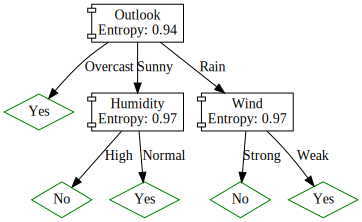

In [244]:
tree.dot

#### Mushroom test

In [246]:
tree = ID3(x_mushroom, labels_mushroom, "information_gain", True)

print('Mushroom test on train with Gini Index:')
print('Accuracy: {}%'.format(
    performance(x_mushroom, labels_mushroom, split_type="information_gain", giny=True)
))

Mushroom test on train with Gini Index:
Accuracy: 100.0%


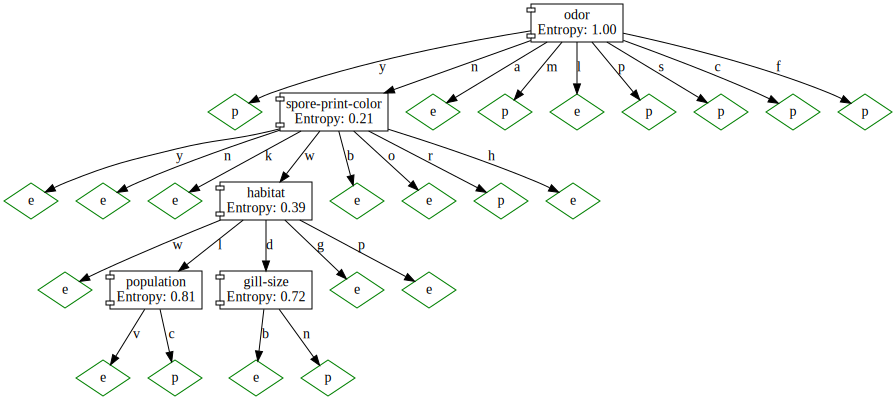

In [247]:
tree.dot

### Gain Ratio & Gini

#### PlayTennis test

In [251]:
tree = ID3(x_tennis, labels_tennis, "gain_ratio", True)

print('PlayTennis test on train with Gini Index:')
print('Accuracy: {:.2f}%'.format(
    performance(x_tennis, labels_tennis, split_type="gain_ratio", giny=True)
))

PlayTennis test on train with Gini Index:
Accuracy: 85.71%


#### Mushroom test

In [250]:
tree = ID3(x_mushroom, labels_mushroom, "gain_ratio", True)

print('Mushroom test on train with Gini Index:')
print('Accuracy: {}%'.format(
    performance(x_mushroom, labels_mushroom, split_type="gain_ratio", giny=True)
))

Mushroom test on train with Gini Index:
Accuracy: 100.0%


## Cross validation

### PlayTennis

In [252]:
def cross_validation(x, y):
    nb_test = (int)(len(y) * 0.8)
    
    x_train = x[0:nb_test]
    y_train = y[0:nb_test]
    
    x_test = x[nb_test:len(y)].reset_index(drop=True)
    y_test = y[nb_test:len(y)]
    
    print('Accuracy: {:.2f}%'.format(
        performance(
            x_train, y_train, x_test=x_test, y_test=y_test,
            split_type="information_gain"
        )
    ))

In [253]:
print('Performance on PlayTennis with 80% of tests for cross validation:')
cross_validation(x_tennis, labels_tennis)

Performance on PlayTennis with 80% of tests for cross validation:
Accuracy: 100.00%


### Mushroom

In [111]:
print('Performance on Mushroom with 80% of tests for cross validation:')
cross_validation(x_mushroom, labels_mushroom)

Performance on Mushroom with 80% of tests for cross validation:
Accuracy: 96.55%
